In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('arxiv_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [7]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [9]:
df = df.drop_duplicates(subset=['titles', 'summaries'])

In [11]:
df = df.dropna()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38985 entries, 0 to 51772
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     38985 non-null  object
 1   summaries  38985 non-null  object
 2   terms      38985 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


### Document Length Analysis
We analyze the distribution of summaries length to understand content variation.


In [16]:
# Sample 100 rows
df_sample = df.sample(n=1000, random_state=42)

count    1000.000000
mean      171.464000
std        46.254256
min        38.000000
25%       139.000000
50%       170.000000
75%       201.000000
max       307.000000
Name: summary_length, dtype: float64


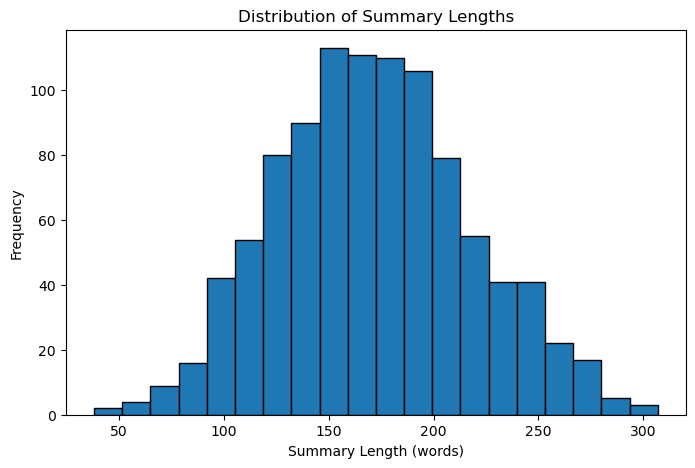

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Compute document lengths
df_sample["summary_length"] = df_sample["summaries"].apply(lambda x: len(x.split()))

# Display summary statistics
print(df_sample["summary_length"].describe())

# Plot histogram of document lengths
plt.figure(figsize=(8,5))
plt.hist(df_sample["summary_length"], bins=20, edgecolor='black')
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Summary Lengths")
plt.show()


In [19]:
# 3. Vocabulary Size Calculation
# To get an estimate of the dataset's vocabulary size:

from collections import Counter

# Join all text data and count unique words
all_words = " ".join(df_sample["summaries"]).split()
vocab_count = Counter(all_words)

print(f"Vocabulary size: {len(vocab_count)}")

Vocabulary size: 18325


               Topic  Count
0              cs.CV    571
4              cs.LG    565
5            stat.ML    302
7              cs.AI    148
12             cs.RO     39
..               ...    ...
71             65K10      1
72             G.1.6      1
74             97R40      1
75     I.2.11; I.2.6      1
112  physics.comp-ph      1

[113 rows x 2 columns]


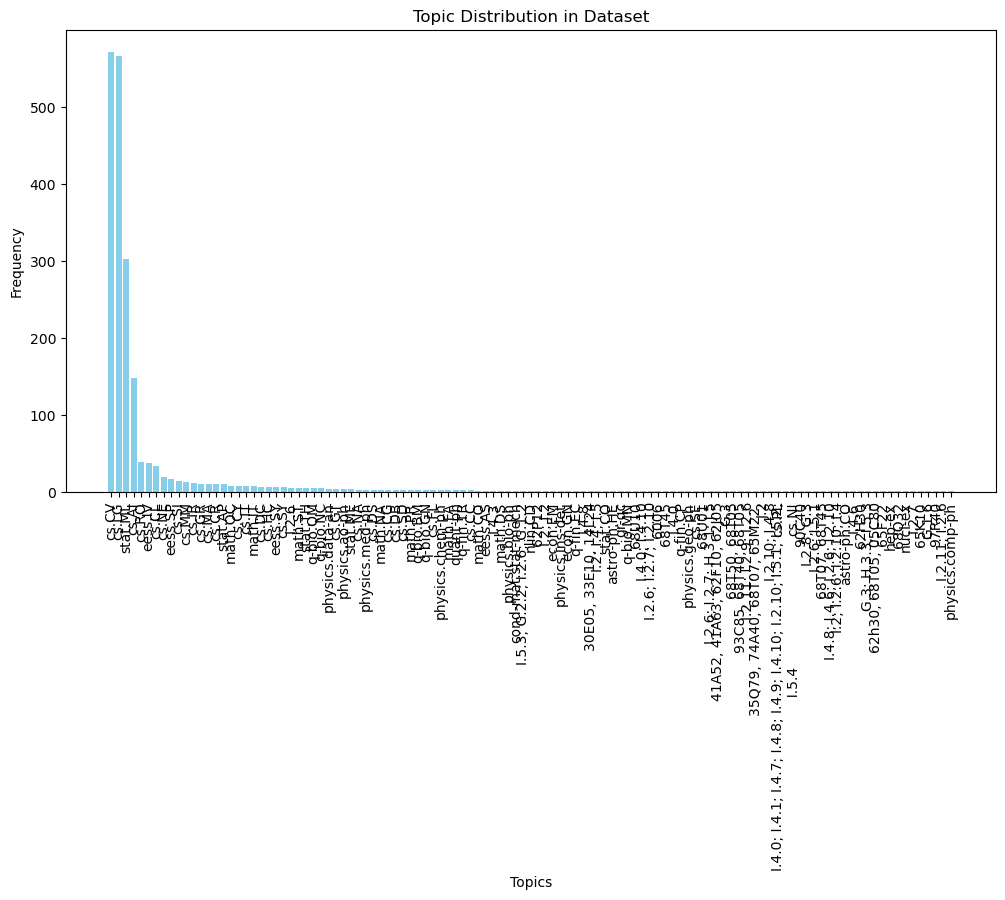

In [22]:
# # 4. Topic Distribution Analysis
# # The terms column contains multiple topic labels per document. We will flatten and count their occurrences.

# from collections import Counter
# import pandas as pd
# import matplotlib.pyplot as plt

# # Count occurrences of each unique title (topic)
# topic_counts = df["terms"].value_counts()

# # Convert to DataFrame for visualization
# topic_df = topic_counts.reset_index()
# topic_df.columns = ["Topic", "Count"]

# # Display topic frequency
# print(topic_df)

# # Plot topic distribution
# plt.figure(figsize=(10, 5))
# plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
# plt.xticks(rotation=90)  # Rotate for better readability if too many topics
# plt.xlabel("Topics")
# plt.ylabel("Frequency")
# plt.title("Topic Distribution in Dataset")
# plt.show()

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast  # To safely convert string lists into actual lists

# Flatten the topic lists
all_topics = []
for topics in df_sample["terms"]:
    topic_list = ast.literal_eval(topics)  # Convert string list to actual list
    all_topics.extend(topic_list)  # Add all topics to a single list

# Count occurrences of each unique topic
topic_counts = Counter(all_topics)

# Convert to DataFrame for visualization
topic_df = pd.DataFrame(topic_counts.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

# Display topic frequency
print(topic_df)

# Plot topic distribution
plt.figure(figsize=(12, 6))
plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
plt.xticks(rotation=90)  # Rotate for better readability if too many topics
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.title("Topic Distribution in Dataset")
plt.show()


In [26]:
# !pip install sentencepiece


Unable to create process using 'C:\Users\Mohammed Thoufiq\Downloads\New_folder\python.exe "C:\Users\Mohammed Thoufiq\Downloads\New_folder\Scripts\pip-script.py" install sentencepiece'


In [24]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load models
embedding_model = SentenceTransformer('BAAI/bge-small-en')
generation_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')


# 2. Hardcoded Questions (replace dynamic generation)
hardcoded_questions = [
    "What does deep reinforcement learning combine?", #['cs.CV', 'cs.AI']
    "What is the main focus of the research in this paper regarding Blockchain technologies?", #['cs.LG', 'q-fin.ST', 'stat.ML']
    "What does pose information represent in Capsule Networks?", #['cs.CV', 'cs.LG']
    "What are the key components of VA-GAN?", #['cs.CV']
    "How does the paper contribute to understanding the network dynamics behind cryptocurrencies like Bitcoin?",#['cs.LG', 'q-fin.ST', 'stat.ML']
    "What specific image processing algorithms were used to transform RNA sequences into gene motifs for the CNN classification?", #['cs.LG', 'q-bio.QM']
    "What is the role of camera-aware domain adaptation in the proposed method?", #['cs.CV']
    "What is the primary goal of the Structure Transfer Machine (STM) method?", #['cs.CV', 'cs.RO', 'eess.IV']
    "What is the role of the manifold structure in STM?", #['cs.CV', 'cs.RO', 'eess.IV']
    "Where can the source code for STM be accessed?", #['cs.CV', 'cs.RO', 'eess.IV']
    "What are the three main challenges in multi-task reinforcement learning?", #['cs.LG', 'cs.AI', 'stat.ML']
    "What is the main goal of self-supervised methods in reinforcement learning?", #['cs.LG', 'cs.CV', 'stat.ML']
    "How does the proposed Local and Global Diffusion (LGD) framework address this limitation?", #['cs.LG', 'cs.SI', 'stat.ML']
    "What is the role of diffusions in the LGD network?",  #['cs.LG', 'cs.SI', 'stat.ML']
    "How many categories and images are included in the UDD dataset?" #['cs.CV']
]

# 3. Evaluate RAG Model based on hardcoded questions
def evaluate_rag(df, questions, top_k=3):
    results = []

    for question in questions:
        # Embed the question
        query_embedding = embedding_model.encode(question, convert_to_tensor=True)

        # Embed all documents in the dataset
        doc_embeddings = embedding_model.encode(df['summaries'].tolist(), convert_to_tensor=True)

        # Retrieve top-k relevant documents based on similarity
        similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings)[0]

        # Make a copy of the array to avoid negative stride errors
        similarities_copy = similarities.cpu().numpy().copy()

        top_indices = np.argsort(similarities_copy)[-top_k:][::-1]

        retrieved_docs = df.iloc[top_indices]

        # Generate an answer based on the retrieved documents
        doc_context = " ".join(retrieved_docs['summaries'].tolist())
        input_text = f"Answer the question: {question} Based on the following documents: {doc_context[:1500]}"

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="longest", max_length=1024)
        outputs = generation_model.generate(**inputs, max_length=150, num_return_sequences=1)
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Store the results
        results.append({
            'question': question,
            'answer': answer,
            'retrieved_docs': retrieved_docs['summaries'].tolist(),
            'retrieved_titles': retrieved_docs['titles'].tolist(),
            'retrieved_terms': retrieved_docs['terms'].tolist(),
            'similarities': similarities_copy[top_indices].tolist()  # Using the copied similarities array
        })

    return pd.DataFrame(results)

ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [15]:
# Get results from the RAG evaluation
results_df = evaluate_rag(df_sample, hardcoded_questions)

In [16]:
# Save Final Results
results_df.to_csv('rag_evaluation_results.csv', index=False)
print("Evaluation completed and results saved to 'rag_evaluation_results.csv'.")

Evaluation completed and results saved to 'rag_evaluation_results.csv'.


In [31]:
query = "What is the role of convolutional neural networks in computer vision?"
retrieved_docs = retrieve_documents(query, k=3)

print("Retrieved Documents:")
# print("Columns in retrieved_docs:", retrieved_docs.columns)
print(retrieved_docs[["titles", "summaries"]])  # Print titles & summaries of retrieved docs


Retrieved Documents:
                                                  titles  \
10969  A Comparison of Deep Learning Classification M...   
3841   Texture Synthesis Using Convolutional Neural N...   
5441   Object detection for crabs in top-view seabed ...   

                                               summaries  
10969  In recent years, deep learning has made brilli...  
3841   Here we introduce a new model of natural textu...  
5441   This report presents the application of object...  


In [24]:
# Example query test
query = "What is the role of convolutional neural networks in computer vision?"
response = generate_response(query, k=3)
print("Generated Response:", response)

Generated Response: (iii)


In [26]:
import sys
print(sys.executable)

C:\Users\Mohammed Thoufiq\Downloads\New_folder\python.exe
